# Preprocessing and Exploration

## Preprocessing

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', '.*')

sns.set(style='white', context='notebook', palette='deep')

np.random.seed(seed=2)

In [2]:
# Read credit trade file for preprocessing
trade_file_name = "/home/jg/recom/PR_Credittrades.xlsx"
trade_file_real = pd.read_excel(trade_file_name)
trade_file = trade_file_real.copy(deep=True)

In [3]:
def autolabel(arrayA):
    ''' label each colored square with the corresponding data value. 
    If value > 20, the text is in black, else in white.
    '''
    arrayA = np.array(arrayA)
    for i in range(arrayA.shape[0]):
        for j in range(arrayA.shape[1]):
                plt.text(j,i, "%.2f"%arrayA[i,j], ha='center', va='bottom',color='w')

def gt_matrix(feats,sz=16):
    a = []
    for i,c1 in enumerate(feats):
        b = [] 
        for j,c2 in enumerate(feats):
            mask = (~trade_file[c1].isnull()) & (~trade_file[c2].isnull())
            if i>=j:
                b.append((trade_file.loc[mask,c1].values>=trade_file.loc[mask,c2].values).mean())
            else:
                b.append((trade_file.loc[mask,c1].values>trade_file.loc[mask,c2].values).mean())

        a.append(b)
    
    plt.figure(figsize = (sz,sz))
    plt.imshow(a, interpolation = 'None')
    _ = plt.xticks(range(len(feats)),feats,rotation = 90)
    _ = plt.yticks(range(len(feats)),feats,rotation = 0)
    autolabel(a)

## shape

In [4]:
print ('Trade file shape: %d rows and %d columns' % (trade_file.shape[0], trade_file.shape[1]))

Trade file shape: 6918 rows and 22 columns


## Number of missing value in each row

In [5]:
# Number of NaNs for each object
trade_file.isnull().sum(axis=1).sort_values(ascending=False)[:15]

281    7
257    7
207    7
208    7
184    7
41     7
75     7
52     7
256    7
209    7
5      7
177    7
211    7
2      7
1      7
dtype: int64

## Number of missing value in each column

In [6]:
# Number of NaNs for each column
trade_file.isnull().sum(axis=0).sort_values(ascending=False)

yearssinceissuance    6918
ttm                   6918
mktspread              620
parspread              583
oasspread              539
ispread                528
amountoutstanding       16
quantity                 0
price                    0
counterparty             0
ticker                   0
cusip                    0
coupon                   0
couponstructure          0
issuedate                0
maturitydate             0
industrysect             0
rating                   0
sector                   0
creditquality            0
buysellind               0
tradedate                0
dtype: int64

## Remove constant features

In [7]:
# `dropna = False` makes nunique treat NaNs as a distinct value
feats_counts = trade_file.nunique(dropna = False)

In [8]:
feats_counts.sort_values()[:10]

yearssinceissuance      1
ttm                     1
buysellind              3
creditquality           3
couponstructure         5
tradedate              17
rating                 20
amountoutstanding      77
counterparty          103
industrysect          207
dtype: int64

In [9]:
constant_features = feats_counts.loc[feats_counts==1].index.tolist()
print (constant_features)


trade_file.drop(constant_features,axis = 1,inplace=True)

['ttm', 'yearssinceissuance']


## Remove duplicated features

In [10]:
trade_file.fillna('NaN', inplace=True)

In [11]:
trade_file_enc =  pd.DataFrame(index = trade_file.index)

for col in tqdm_notebook(trade_file.columns):
    trade_file_enc[col] = trade_file[col].factorize()[0]

In [12]:
dup_cols = {}

for i, c1 in enumerate(tqdm_notebook(trade_file_enc.columns)):
    for c2 in trade_file_enc.columns[i + 1:]:
        if c2 not in dup_cols and np.all(trade_file_enc[c1] == trade_file_enc[c2]):
            dup_cols[c2] = c1

In [13]:
dup_cols

{'sector': 'industrysect'}

In [14]:
trade_file.drop(dup_cols.keys(), axis = 1,inplace=True)

In [15]:
trade_file['stripissuedate'] = pd.to_datetime(trade_file['issuedate'])
trade_file['stripmaturitydate'] = pd.to_datetime(trade_file['maturitydate'])
trade_file['difference'] = (trade_file['stripmaturitydate'] - trade_file['stripissuedate']) \
                   .astype('timedelta64[D]')

In [16]:
trade_file = trade_file.drop(['tradedate', 'issuedate', 'stripissuedate', \
            'maturitydate', 'stripmaturitydate'], axis=1)

## Determine types

In [17]:
nunique = trade_file.nunique(dropna=False)
nunique

quantity              575
price                4988
counterparty          103
ticker                640
cusip                2173
coupon                258
amountoutstanding      77
couponstructure         5
industrysect          207
rating                 20
creditquality           3
buysellind              3
oasspread             874
parspread             838
mktspread             821
ispread               896
difference            752
dtype: int64

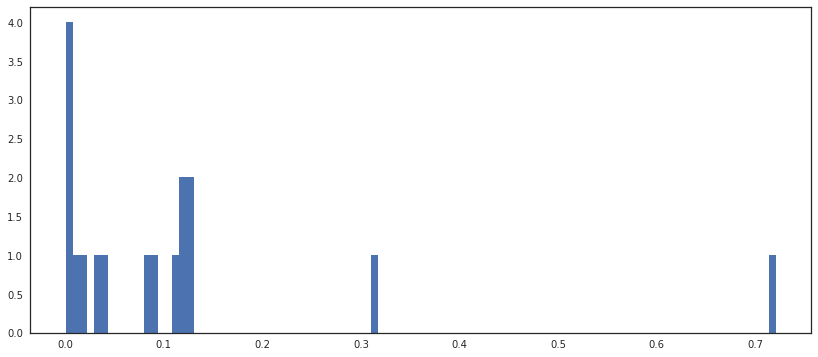

In [18]:
plt.figure(figsize=(14,6))
_ = plt.hist(nunique.astype(float)/trade_file.shape[0], bins=100)

In [19]:
mask = (nunique.astype(float)/trade_file.shape[0] > 0.8)
trade_file.loc[:, mask][:15]

""
0
1
2
3
4
5
6
7
8
9


In [20]:
mask = (nunique.astype(float)/trade_file.shape[0] < 0.8) & (nunique.astype(float)/trade_file.shape[0] > 0.4)
trade_file.loc[:22, mask]

,price
0,98.750000
1,99.985778
2,99.985778
3,100.875000
4,98.250000
5,99.990556
6,101.335000
7,101.500000
8,104.250000
9,83.000000


In [21]:
trade_file['price'].value_counts()

106.019800    58
90.370000     45
109.572000    42
100.000000    29
101.000000    21
102.000000    18
100.500000    18
100.250000    18
101.500000    16
100.750000    14
106.849000    14
107.999000    14
97.898640     14
58.000000     14
102.500000    13
104.250000    13
99.750000     13
99.000000     13
99.500000     13
93.658000     12
105.250000    12
98.750000     12
97.125000     11
100.115000    11
103.500000    11
101.250000     9
98.500000      9
102.729000     9
103.250000     9
102.250000     9
              ..
100.589000     1
99.540000      1
100.196000     1
99.907000      1
98.315000      1
99.425000      1
100.509000     1
96.048000      1
111.017000     1
100.249000     1
98.161000      1
107.962400     1
104.358000     1
99.625837      1
101.170000     1
103.502000     1
86.180000      1
101.390820     1
99.772000      1
100.712000     1
88.374000      1
91.726000      1
43.500000      1
118.500000     1
89.500000      1
112.163000     1
81.750000      1
92.228000     

In [22]:
cat_cols = list(trade_file.select_dtypes(include=['object']).columns)
num_cols = list(trade_file.select_dtypes(exclude=['object']).columns)

In [23]:
trade_file.replace('NaN', -999, inplace=True)

In [24]:
num_cols

['quantity', 'price', 'coupon', 'difference']

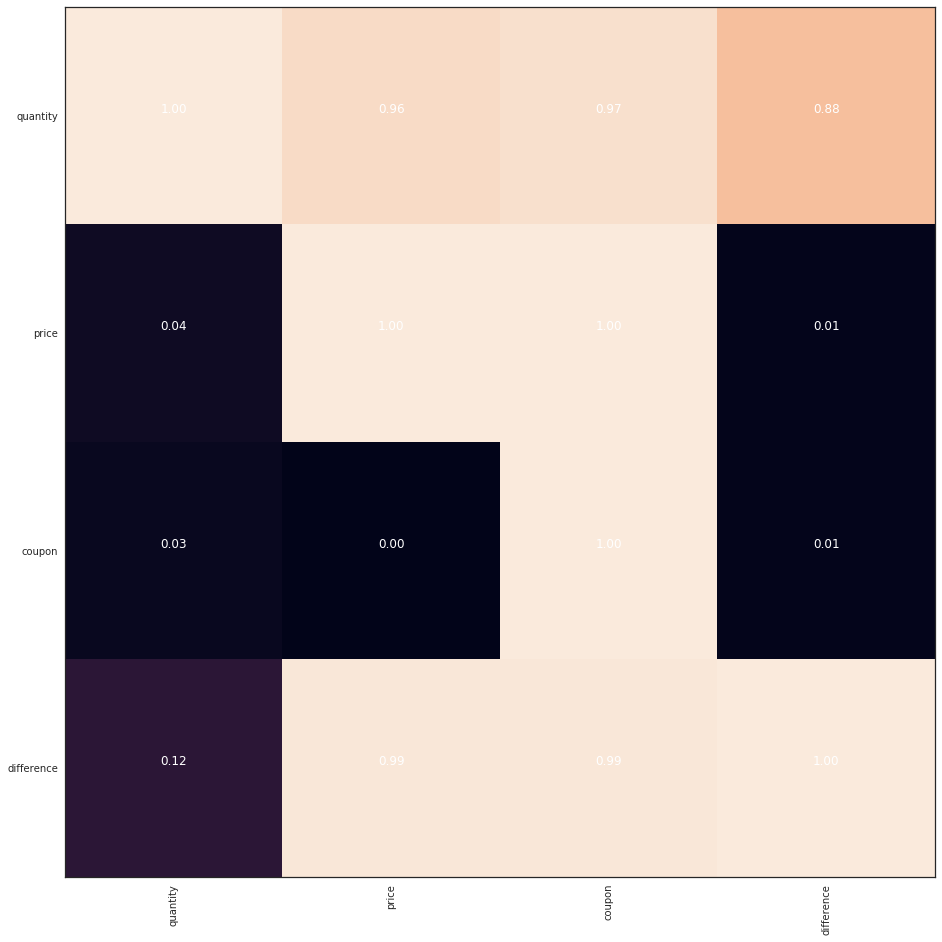

In [25]:
# select first 42 numeric features
feats = num_cols

# build 'mean(feat1 > feat2)' plot
gt_matrix(feats,16)

In [26]:
trade_file.loc[:,cat_cols].head().T

,0,1,2,3,4
counterparty,BLACKROCK_FINANCIAL_MANAGEMENT_INC_AS_AGT,GOLDMAN_SACHS_ASSET_MANAGEMENT_LP_AS_AGT,GOLDMAN_SACHS_ASSET_MANAGEMENT_LP_AS_AGT,KKR_CREDIT_ADVISORS_US_LLC,NOMURA_CORPORATE_RESEARCH__ASSET_MGMT_INCAS_AGT
ticker,S,NRWBK,NRWBK,TIBX,AES
cusip,85207UAF2,62939MUL9,62939MUL9,05765WAA1,00130HBU8
amountoutstanding,4.2489e+09,-999,-999,9.5e+08,7.5e+08
couponstructure,FIXED,ZERO COUPON,ZERO COUPON,FIXED,FIXED
industrysect,Cellular Telecom,Special Purpose Banks,Special Purpose Banks,Internet Infrastr Sftwr,Electric-Integrated
rating,B+,AA+,AA+,B-,BB-
creditquality,HY,SHORT,SHORT,HY,HY
buysellind,S,B,B,B,S
oasspread,-999,-999,-999,-999,-999


## Exploration

## Global data exploration

In [27]:
trade_file.columns

Index(['quantity', 'price', 'counterparty', 'ticker', 'cusip', 'coupon',
       'amountoutstanding', 'couponstructure', 'industrysect', 'rating',
       'creditquality', 'buysellind', 'oasspread', 'parspread', 'mktspread',
       'ispread', 'difference'],
      dtype='object')

In [28]:
num_cols

['quantity', 'price', 'coupon', 'difference']

In [29]:
cat_cols

['counterparty',
 'ticker',
 'cusip',
 'amountoutstanding',
 'couponstructure',
 'industrysect',
 'rating',
 'creditquality',
 'buysellind',
 'oasspread',
 'parspread',
 'mktspread',
 'ispread']

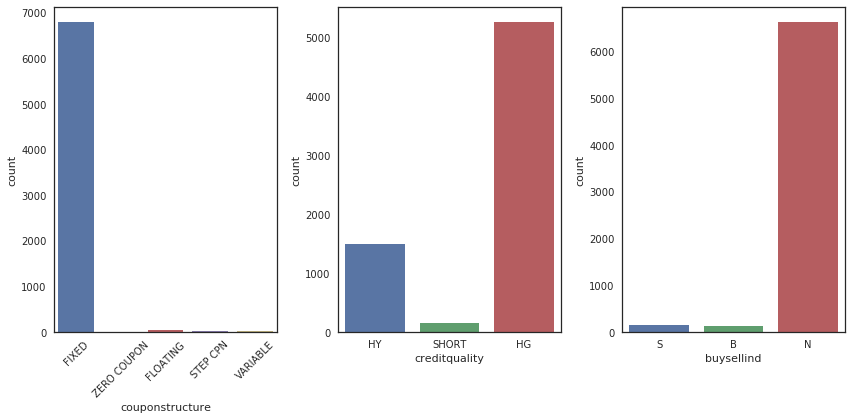

In [30]:
fig, axs = plt.subplots(ncols=3,figsize=(12,6))
g = sns.countplot(trade_file["couponstructure"], ax=axs[0])
plt.setp(g.get_xticklabels(), rotation=45)
g = sns.countplot(trade_file["creditquality"], ax=axs[1])
g = sns.countplot(trade_file["buysellind"], ax=axs[2])
plt.tight_layout()
plt.show()
plt.gcf().clear()

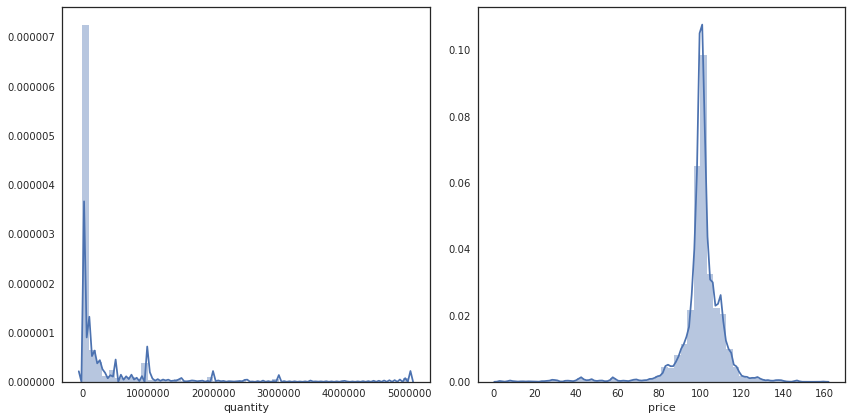

In [31]:
fig, axs = plt.subplots(ncols=2,figsize=(12,6))
sns.distplot(trade_file["quantity"], ax=axs[0])
sns.distplot(trade_file["price"], ax=axs[1])
plt.tight_layout()
plt.show()
plt.gcf().clear()

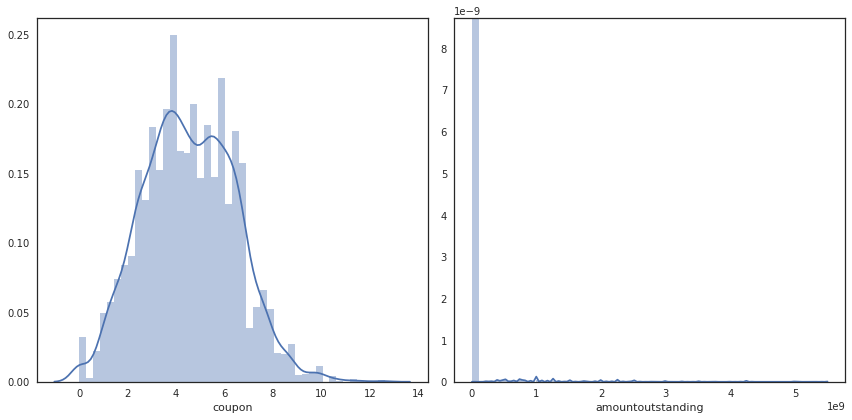

In [32]:
fig, axs = plt.subplots(ncols=2,figsize=(12,6))
sns.distplot(trade_file["coupon"], ax=axs[0])
sns.distplot(trade_file["amountoutstanding"], ax=axs[1])
plt.tight_layout()
plt.show()
plt.gcf().clear()

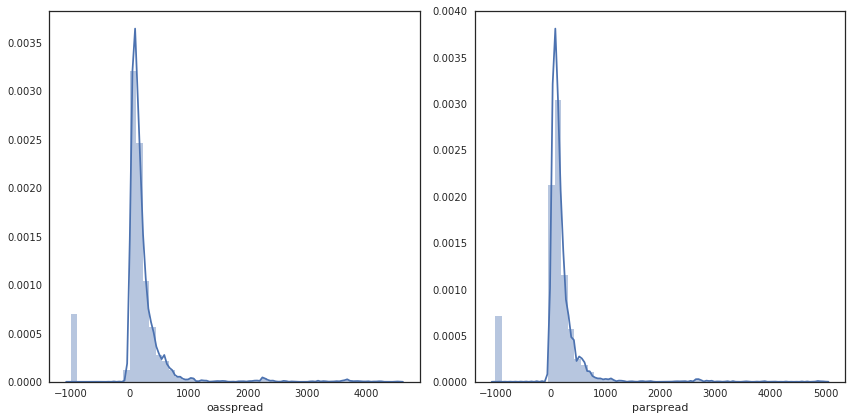

In [33]:
fig, axs = plt.subplots(ncols=2,figsize=(12,6))
sns.distplot(trade_file["oasspread"], ax=axs[0])
sns.distplot(trade_file["parspread"], ax=axs[1])
plt.tight_layout()
plt.show()
plt.gcf().clear()

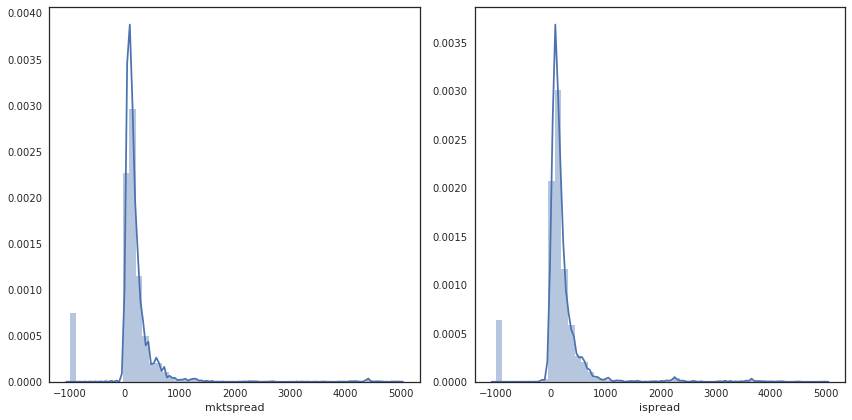

In [34]:
fig, axs = plt.subplots(ncols=2,figsize=(12,6))
sns.distplot(trade_file["mktspread"], ax=axs[0])
sns.distplot(trade_file["ispread"], ax=axs[1])
plt.tight_layout()
plt.show()
plt.gcf().clear()

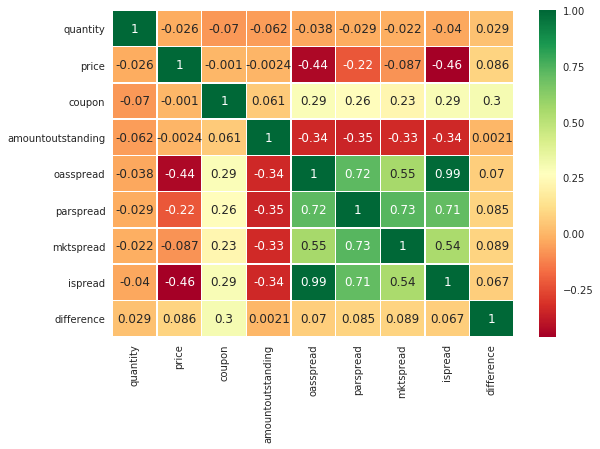

In [35]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(trade_file.corr(), annot=True, linewidths=.5, ax=ax, cmap="RdYlGn")

## Convert Rating features  

In [36]:
# get unique values
rating = trade_file.rating.unique()
rating

array(['B+', 'AA+', 'B-', 'BB-', 'Unknown', 'BBB-', 'B', 'BB+', 'BB',
       'BBB', 'CCC+', 'BBB+', 'A-', 'A+', 'A', 'AA-', 'CCC', 'AA', 'CCC-',
       'AAA'], dtype=object)

In [37]:
def convert_rating(rating):
    if rating == 'AAA':
        return 20
    elif rating == 'AA+':
        return 19
    elif rating == 'AA':
        return 18
    elif rating == 'AA-':
        return 17
    elif rating == 'A+':
        return 16
    elif rating == 'A':
        return 15
    elif rating == 'A-':
        return 14
    elif rating == 'BBB+':
        return 13
    elif rating == 'BBB':
        return 12
    elif rating == 'BBB-':
        return 11
    elif rating == 'BB+':
        return 10
    elif rating == 'BB':
        return 9
    elif rating == 'BB-':
        return 8
    elif rating == 'B+':
        return 7
    elif rating == 'B':
        return 6
    elif rating == 'B-':
        return 5
    elif rating == 'CCC+':
        return 4
    elif rating == 'CCC':
        return 3
    elif rating == 'CCC-':
        return 2
    else:
        return 1

In [38]:
trade_file.rating = trade_file.rating.apply(convert_rating)

In [39]:
trade_file.head().T

,0,1,2,3,4
quantity,3,40,40,4.576,0.5
price,98.75,99.9858,99.9858,100.875,98.25
counterparty,BLACKROCK_FINANCIAL_MANAGEMENT_INC_AS_AGT,GOLDMAN_SACHS_ASSET_MANAGEMENT_LP_AS_AGT,GOLDMAN_SACHS_ASSET_MANAGEMENT_LP_AS_AGT,KKR_CREDIT_ADVISORS_US_LLC,NOMURA_CORPORATE_RESEARCH__ASSET_MGMT_INCAS_AGT
ticker,S,NRWBK,NRWBK,TIBX,AES
cusip,85207UAF2,62939MUL9,62939MUL9,05765WAA1,00130HBU8
coupon,7.875,0,0,11.375,5.5
amountoutstanding,4.2489e+09,-999,-999,9.5e+08,7.5e+08
couponstructure,FIXED,ZERO COUPON,ZERO COUPON,FIXED,FIXED
industrysect,Cellular Telecom,Special Purpose Banks,Special Purpose Banks,Internet Infrastr Sftwr,Electric-Integrated
rating,7,19,19,5,8


In [40]:
trade_file.dtypes

quantity             float64
price                float64
counterparty          object
ticker                object
cusip                 object
coupon               float64
amountoutstanding    float64
couponstructure       object
industrysect          object
rating                 int64
creditquality         object
buysellind            object
oasspread            float64
parspread            float64
mktspread            float64
ispread              float64
difference           float64
dtype: object

In [41]:
cat_cols = list(trade_file.select_dtypes(include=['object']).columns)
num_cols = list(trade_file.select_dtypes(exclude=['object']).columns)

In [42]:
cat_cols

['counterparty',
 'ticker',
 'cusip',
 'couponstructure',
 'industrysect',
 'creditquality',
 'buysellind']

In [43]:
from sklearn.preprocessing import StandardScaler

N = StandardScaler()
N.fit(trade_file[num_cols])
trade_file_norm = N.transform(trade_file[num_cols])

In [44]:
trade_file_norm.shape

(6918, 10)

In [69]:
trade_file_lenc = pd.DataFrame({})
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for c in cat_cols:
    trade_file_lenc[c] = le.fit_transform(trade_file[c])

In [47]:
dataset_target = trade_file_lenc['counterparty']
trade_file_lenc.drop('counterparty', axis=1, inplace=True)

In [48]:
dataset_features = np.concatenate((trade_file_norm, trade_file_lenc), axis=1)

In [49]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10)

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

DTC = DecisionTreeClassifier(max_depth=3)
cv_results = cross_val_score(DTC, dataset_features, dataset_target.values, cv=kfold, scoring="accuracy")
cv_results.mean()

0.96637662174263783

In [51]:
DTC.fit(dataset_features, dataset_target.values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [52]:
train_features = num_cols+cat_cols
train_features.remove('counterparty')
train_features = pd.Index(train_features)

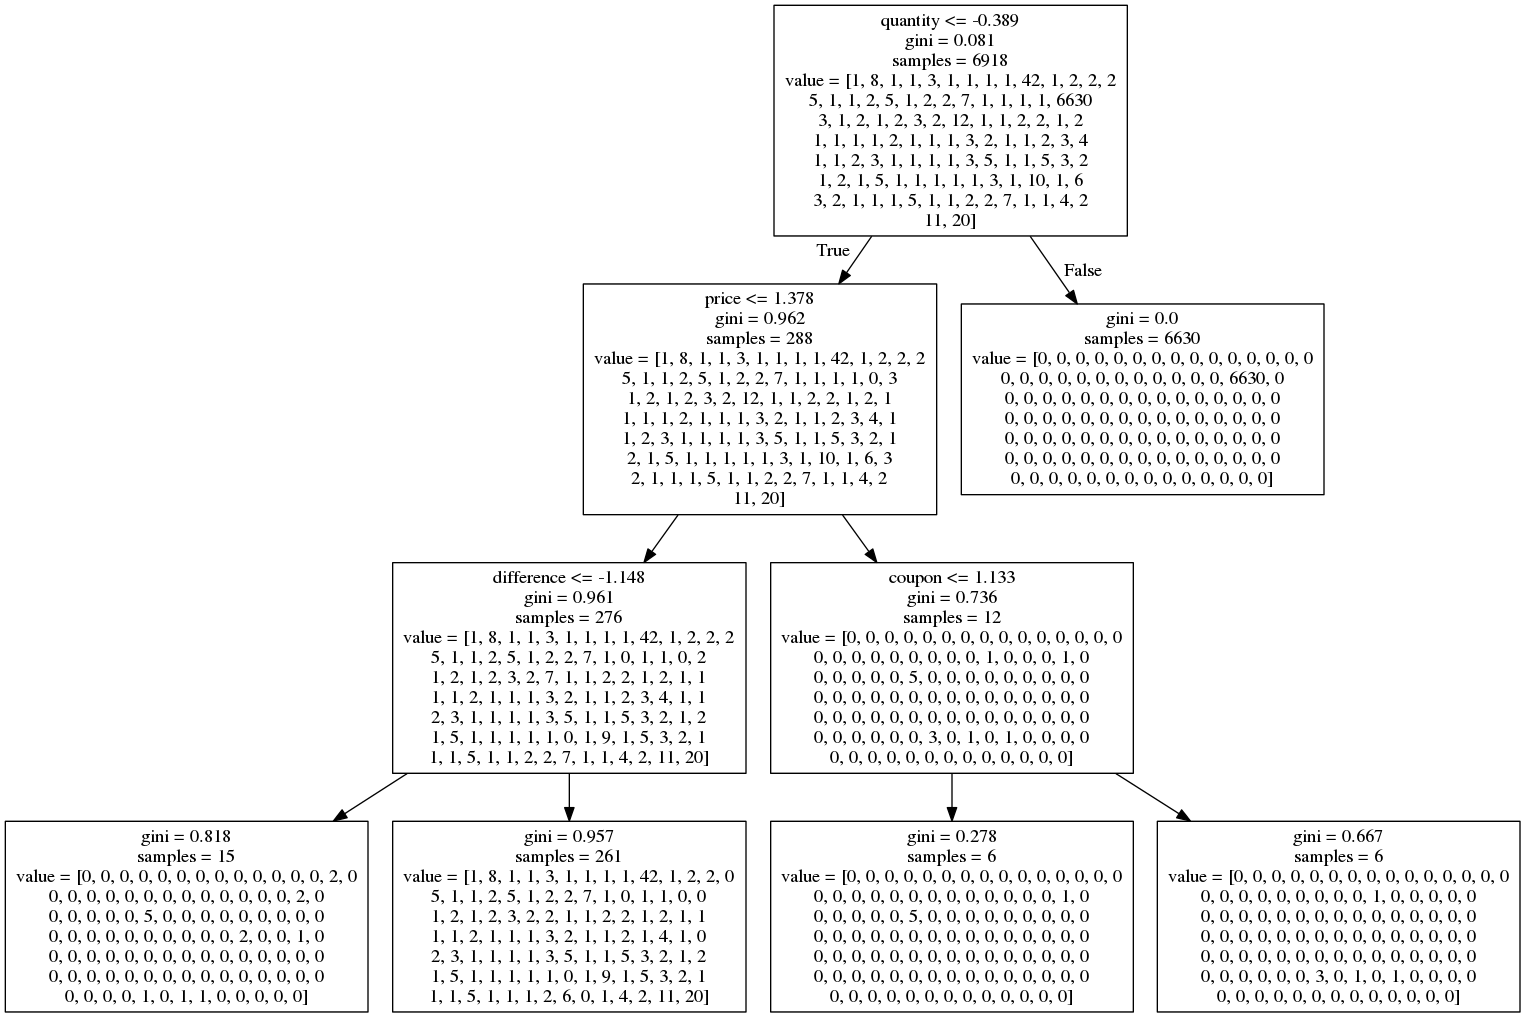

In [53]:
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn import tree
import pydot
import pydotplus as pydot

dot_data = StringIO()

tree.export_graphviz(DTC, out_file=dot_data, feature_names=train_features)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
graph.set_lwidth(400)
graph.set_lheight(300)

Image(graph.create_png())

In [54]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
cv_results = cross_val_score(RFC, dataset_features, dataset_target.values, cv=kfold, scoring="accuracy")
cv_results.mean()

0.97137969468568686

In [55]:
RFC.fit(dataset_features, dataset_target.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [56]:
RFC.feature_importances_

array([ 0.21800983,  0.07360754,  0.05684087,  0.23733811,  0.04358117,
        0.        ,  0.02329415,  0.        ,  0.09029276,  0.05509374,
        0.05169157,  0.04366974,  0.00563847,  0.04902915,  0.00803898,
        0.04387394])

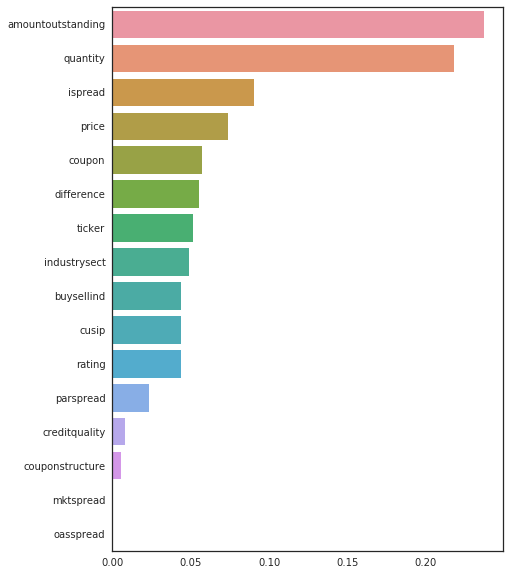

In [57]:
indices = np.argsort(RFC.feature_importances_)[::-1]

fig = plt.figure(figsize=(7, 10))
g = sns.barplot(y=train_features[indices] ,x=RFC.feature_importances_[indices], orient='h')

In [70]:
train_list = []
for l1, l2 in zip(np.ndarray.tolist(dataset_features), np.ndarray.tolist(trade_file['counterparty'].values)):
    l1.append(l2)
    train_list.append(l1)

In [71]:
train_list

[[-0.3902871273171134,
  -0.12195339581207061,
  1.7587993604267464,
  13.20080790016519,
  -1.7221982579399329,
  -2.1467693855629495,
  -2.2086570571410067,
  -2.1032173656412194,
  -2.1449367387122833,
  -0.2128973712870079,
  499.0,
  1791.0,
  0.0,
  25.0,
  1.0,
  2.0,
  'BLACKROCK_FINANCIAL_MANAGEMENT_INC_AS_AGT'],
 [-0.3902348797567337,
  -0.01934500950375988,
  -2.3895182711674954,
  -0.15898535510335068,
  2.059576919447753,
  -2.1467693855629495,
  -2.2086570571410067,
  -2.1032173656412194,
  -2.1449367387122833,
  -1.204768766139936,
  420.0,
  1427.0,
  4.0,
  187.0,
  2.0,
  0.0,
  'GOLDMAN_SACHS_ASSET_MANAGEMENT_LP_AS_AGT'],
 [-0.3902348797567337,
  -0.01934500950375988,
  -2.3895182711674954,
  -0.15898535510335068,
  2.059576919447753,
  -2.1467693855629495,
  -2.2086570571410067,
  -2.1032173656412194,
  -2.1449367387122833,
  -1.204768766139936,
  420.0,
  1427.0,
  4.0,
  187.0,
  2.0,
  0.0,
  'GOLDMAN_SACHS_ASSET_MANAGEMENT_LP_AS_AGT'],
 [-0.3902849018534605,
  0

In [72]:
import math
def euclideanDistance(instance1, instance2, length):
    distance = 0
    for x in range(length):
        distance += pow((instance1[x] - instance2[x]), 2)
    return math.sqrt(distance)

In [73]:
import operator 
def getNeighbors(trainingSet, testInstance, k):
    distances = []
    length = len(testInstance)-1
    for x in range(len(trainingSet)):
        dist = euclideanDistance(testInstance, trainingSet[x], length)
        distances.append((trainingSet[x], dist))
        distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [74]:
testInstance = [-0.3902871273171134, -0.12195339581207061, 1.7587993604267464, \
                13.20080790016519, -1.7221982579399329, -2.1467693855629495, \
                -2.2086570571410067, -2.1032173656412194, -2.1449367387122833, \
                -0.2128973712870079, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0]
k = 3
neighbors = getNeighbors(train_list, testInstance, k)
print(neighbors)

[[-0.17847692963387082, 0.27136645004441085, -0.7828682678198843, -0.15898221395380044, 1.1141331251008313, -0.18572334189890485, -0.14496260971589903, -0.12123089145718594, -0.17969158421205486, -0.6560133866533829, 3.0, 40.0, 0.0, 30.0, 0.0, 1.0, 'EXTERNAL'], [-0.17847692963387082, 0.291460054160364, -0.7828682678198843, -0.15898221395380044, 1.1141331251008313, -0.17825979844062115, -0.137100916582851, -0.11555726605398738, -0.17221205936143552, -0.6560133866533829, 3.0, 40.0, 0.0, 30.0, 0.0, 1.0, 'EXTERNAL'], [-0.31968655228181886, 0.2593268938592328, -0.7828682678198843, -0.15898221395380044, 1.1141331251008313, -0.16893036911776652, -0.12923922344980296, -0.10610122371532309, -0.16286265329816135, -0.6560133866533829, 3.0, 40.0, 0.0, 30.0, 0.0, 1.0, 'EXTERNAL']]
